In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision
import torchvision.transforms as transforms

from sklearn.model_selection import train_test_split

import os, random
print(os.listdir("../input"))

['test', 'sample_submission.csv', 'train.csv', 'train']


In [2]:
# define data directories 
data_dir = '../input'
train_dir = data_dir + '/train/train/'
test_dir = data_dir + '/test/test/'

In [3]:
# visualize the label map & number of classes
labels = pd.read_csv("../input/train.csv")
labels.head()

,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1


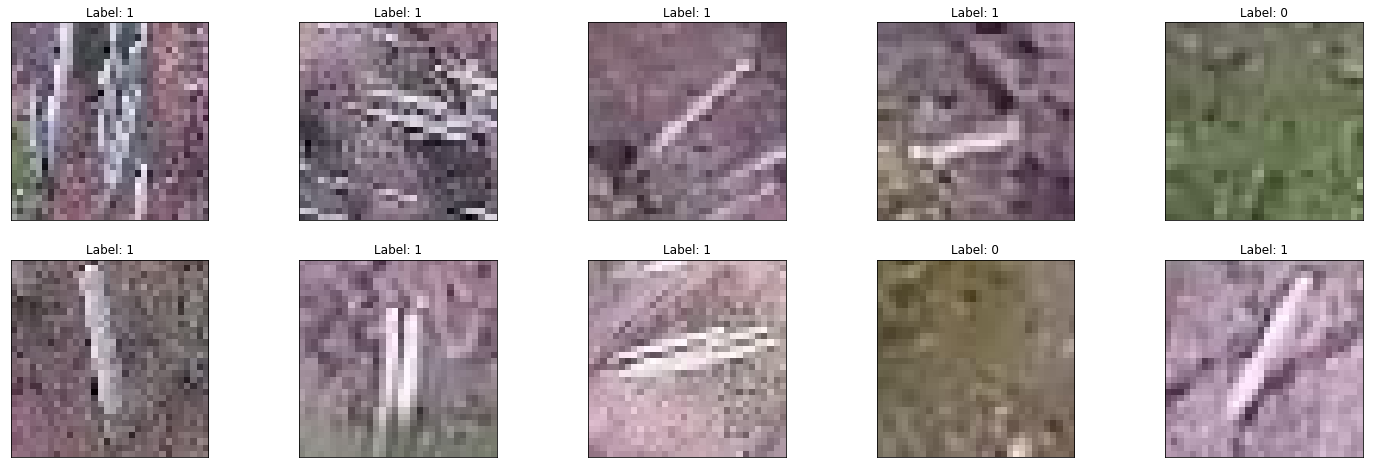

In [4]:
# plot 10 random images from the training dataset
fig = plt.figure(figsize=(25, 8))
train_imgs = os.listdir("../input/train/train")
for idx, img in enumerate(np.random.choice(train_imgs, 10)):
    ax = fig.add_subplot(2, 10//2, idx+1, xticks=[], yticks=[])
    im = mpimg.imread("../input/train/train/" + img)
    plt.imshow(im, cmap="hot")
    lab = labels.loc[labels['id'] == img, 'has_cactus'].values[0]
    ax.set_title(f'Label: {lab}')

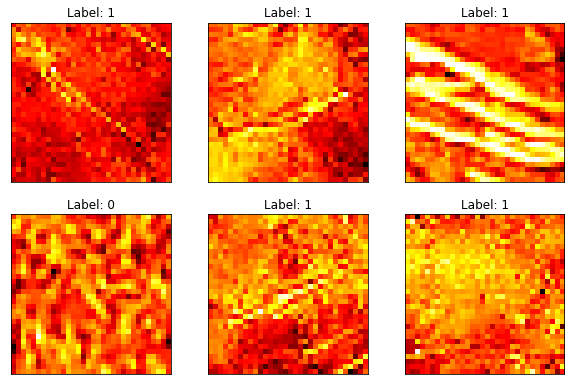

In [5]:
# plot 6 random images with a heatmap from the training dataset
fig = plt.figure(figsize=(10, 10))
train_imgs = os.listdir("../input/train/train")
for idx, img in enumerate(np.random.choice(train_imgs, 6)):
    ax = fig.add_subplot(3, 6//2, idx+1, xticks=[], yticks=[])
    im = mpimg.imread("../input/train/train/" + img)
    lum_img = im[:,:,0]
    plt.imshow(lum_img, cmap="hot")
    lab = labels.loc[labels['id'] == img, 'has_cactus'].values[0]
    ax.set_title(f'Label: {lab}')

In [6]:
# check the balance of the data labels
balance = labels['has_cactus'].value_counts()
print(balance)

1    13136
0     4364
Name: has_cactus, dtype: int64


In [7]:
# lets split the data to create a validation set using train_test_split() 
train, valid = train_test_split(labels, stratify=labels.has_cactus, test_size=0.2)

In [8]:
# this gives us a pretty close 50, 25 , 25 % data split
print('Number of training samples:{0}'.format(len(train)))
print('Number of validation samples:{0}'.format(len(valid)))
print('Number of testing samples:{0}'.format(len(os.listdir(test_dir))))

Number of training samples:14000
Number of validation samples:3500
Number of testing samples:4000


In [9]:
# define hyper-params
num_epochs = 25
num_classes = 2
batch_size = 128
learning_rate = 0.002
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [10]:
# ole reliable - https://stanford.edu/~shervine/blog/pytorch-how-to-generate-data-parallel
class CactiImageData(Dataset):
    def __init__(self, split_data, data_root = './', transform=None):
        super().__init__()
        self.df = split_data.values
        self.data_root = data_root
        self.transform = transform

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img_name,label = self.df[index]
        img_path = os.path.join(self.data_root, img_name)
        image = mpimg.imread(img_path)
        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [11]:
# define some light data augmentation on the training set only
mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]

train_transf = transforms.Compose([transforms.ToPILImage(),
                                   transforms.ToTensor()])

valid_transf = transforms.Compose([transforms.ToPILImage(),
                                  transforms.ToTensor()])

In [12]:
train_data = CactiImageData(split_data = train, data_root = train_dir, transform = train_transf)
valid_data = CactiImageData(split_data = valid, data_root = train_dir, transform = valid_transf)

train_loader = DataLoader(dataset = train_data, batch_size = batch_size, shuffle = True, num_workers = 0)
valid_loader = DataLoader(dataset = valid_data, batch_size = batch_size//2, shuffle = False, num_workers = 0)

In [13]:
# define our model architecture 
class CactiCNN(nn.Module):
    def __init__(self):
        super(CactiCNN, self).__init__()
        self.conv1 = nn.Sequential(
                nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3,stride=1,padding=0),
                nn.BatchNorm2d(32),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2,2))
        self.conv2 = nn.Sequential(
                nn.Conv2d(in_channels=32,out_channels=64,kernel_size=2,stride=1,padding=1),
                nn.BatchNorm2d(64),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2,2))
        self.conv3 = nn.Sequential(
                nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=1,padding=1),
                nn.BatchNorm2d(128),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2,2))
        self.conv4 = nn.Sequential(
                nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,stride=1,padding=1),
                nn.BatchNorm2d(256),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2,2))
        
        self.fc = nn.Sequential(
                nn.Linear(256 * 2 * 2, 1024),
                nn.ReLU(inplace=True),
                nn.Dropout(0.25),
                nn.Linear(1024, 2))

    def forward(self,x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = x.view(x.shape[0],-1)
        x = self.fc(x)
        return x

In [14]:
# define our loss function and optimizer
model = CactiCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [15]:
# train the model - https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
total_step = len(train_loader)

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

Epoch [1/25], Step [100/110], Loss: 0.1072
Epoch [2/25], Step [100/110], Loss: 0.0337
Epoch [3/25], Step [100/110], Loss: 0.0047
Epoch [4/25], Step [100/110], Loss: 0.0381
Epoch [5/25], Step [100/110], Loss: 0.0140
Epoch [6/25], Step [100/110], Loss: 0.0258
Epoch [7/25], Step [100/110], Loss: 0.0547
Epoch [8/25], Step [100/110], Loss: 0.0205
Epoch [9/25], Step [100/110], Loss: 0.0092
Epoch [10/25], Step [100/110], Loss: 0.0118
Epoch [11/25], Step [100/110], Loss: 0.0141
Epoch [12/25], Step [100/110], Loss: 0.0217
Epoch [13/25], Step [100/110], Loss: 0.0482
Epoch [14/25], Step [100/110], Loss: 0.0019
Epoch [15/25], Step [100/110], Loss: 0.0051
Epoch [16/25], Step [100/110], Loss: 0.0027
Epoch [17/25], Step [100/110], Loss: 0.0101
Epoch [18/25], Step [100/110], Loss: 0.0161
Epoch [19/25], Step [100/110], Loss: 0.0416
Epoch [20/25], Step [100/110], Loss: 0.0180
Epoch [21/25], Step [100/110], Loss: 0.0082
Epoch [22/25], Step [100/110], Loss: 0.0289
Epoch [23/25], Step [100/110], Loss: 0.00

In [19]:
# test the models accuracy against the valid dataset
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in valid_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
          
    print('Test Accuracy: {} %'.format(100 * correct / total))

Test Accuracy: 99.0 %


In [20]:
# create a dataset and data loader for the test data
submit = pd.read_csv('../input/sample_submission.csv')
test_data = CactiImageData(split_data = submit, data_root = test_dir, transform = valid_transf)
test_loader = DataLoader(dataset = test_data, batch_size=32, shuffle=False, num_workers=0)

In [18]:
# create a submission file using the data in our test_loader
model.eval()
predict = []
for batch_i, (data, target) in enumerate(test_loader):
    data, target = data.to(device), target.to(device)
    output = model(data)

    pr = output[:,1].detach().cpu().numpy()
    for i in pr:
        predict.append(i)

submit['has_cactus'] = predict
submit.to_csv('submission.csv', index=False)